### Import relevant packages 

In [117]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm

### Import data

In [111]:
BASE_DIR = Path("..") / "data" / "output"

df_empirica_regio = pd.read_csv(
    BASE_DIR / "empirica_regio_data.csv",
    encoding="utf-8-sig",
)
df_empirica_regio["Jahr"] = df_empirica_regio["Jahr"].astype(int)

df_gemeinden_coords = pd.read_csv(BASE_DIR / "Gemeinden_coordinates.csv", encoding="utf-8-sig")

### Analysis

In [112]:
df_zins_jährlich = pd.read_csv(BASE_DIR / "zinsdaten.csv", encoding="utf-8-sig")

df_empirica_regio = df_empirica_regio.merge(df_gemeinden_coords, on="RegionID", how="left")
df_empirica_regio = df_empirica_regio[df_empirica_regio["Regionsebene"] == "Gemeinde"].sort_values("Jahr")
df_empirica_regio = df_empirica_regio[["Regionsname", "lat", "lon", "Jahr", "Kaufpreis/m2 ETW 50%", "Mietpreis/m2 50%", "Wohneigentumsquote"]]

df_buyvsrent = df_empirica_regio.merge(df_zins_jährlich, on="Jahr", how="left")

In [113]:
# assumptions
sqm = 80
tilgung = 1.5

df_buyvsrent["Miete"] = df_buyvsrent["Mietpreis/m2 50%"] * sqm * 12
df_buyvsrent["Annuität"] = df_buyvsrent["Kaufpreis/m2 ETW 50%"] * sqm * ((df_buyvsrent["Zins"]+tilgung)/100)
df_buyvsrent["diff"] = df_buyvsrent["Miete"] - df_buyvsrent["Annuität"]

C:\Users\49176\AppData\Local\Temp\ipykernel_31208\3481297917.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


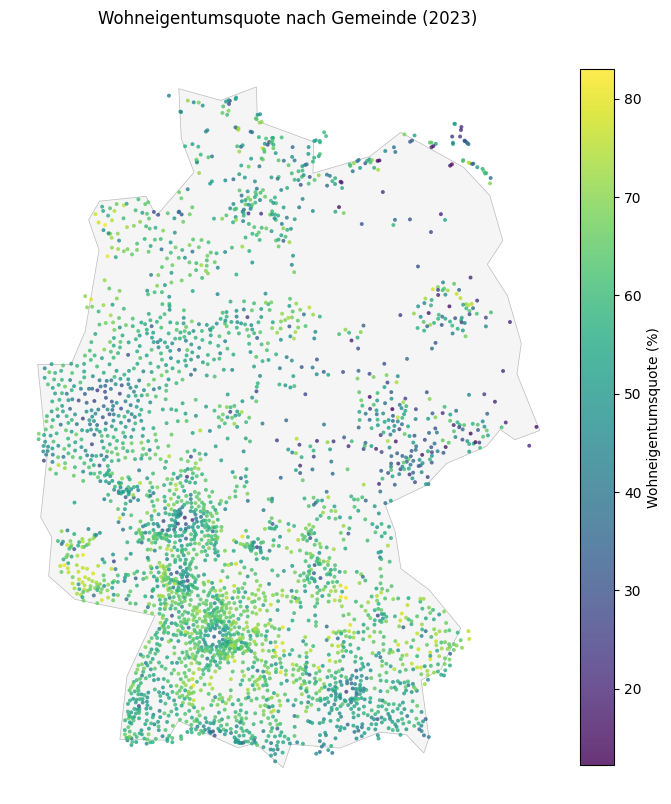

In [121]:
# Daten filtern
df_buyvsrent = df_buyvsrent.dropna(subset=["lon", "lat", "Wohneigentumsquote"])
df_buyvsrent = df_buyvsrent[df_buyvsrent["Jahr"] == 2023]

# GeoDataFrame
gdf_emp = gpd.GeoDataFrame(
    df_buyvsrent,
    geometry=gpd.points_from_xy(df_buyvsrent["lon"], df_buyvsrent["lat"]),
    crs="EPSG:4326"
)

# Deutschland-Umriss (grobes Shape aus GeoPandas mitnutzen)
url = "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
world = gpd.read_file(url)
germany = world[world["SOVEREIGNT"] == "Germany"].to_crs("EPSG:4326")

# Farbskala vorbereiten
values = gdf_emp["Wohneigentumsquote"]
norm = Normalize(vmin=values.min(), vmax=values.max())
cmap = cm.get_cmap("viridis")

fig, ax = plt.subplots(figsize=(7, 9))

# Hintergrundkarte
germany.plot(ax=ax, color="#f5f5f5", edgecolor="#bbbbbb", linewidth=0.5)

# Punkte
sc = ax.scatter(
    gdf_emp["lon"],
    gdf_emp["lat"],
    c=values,
    s=8,
    alpha=0.8,
    cmap=cmap,
    norm=norm,
    linewidths=0
)

# Farbleiste
cbar = fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.02)
cbar.set_label("Wohneigentumsquote (%)", fontsize=10)

# Optik
ax.set_title("Wohneigentumsquote nach Gemeinde (2023)", fontsize=12, pad=12)
ax.set_xlim(5.5, 15.5)
ax.set_ylim(47, 55.5)
ax.set_axis_off()

plt.tight_layout()
plt.show()
